In [3]:
#Import libraries
import torch #For Deep Learning
import numpy as np #For mathematical computations
import pandas as pd #For Data manipulation
import re #Used for text processing
import matplotlib.pyplot as plt #For data visualization
import seaborn as sns #For data visualization
import tensorflow as tf #For deep learning
import evaluate #For performing evaluation metrics
import warnings #To suppress warnings

In [4]:
#Import Hugging Face transformers
from transformers import T5Tokenizer, T5ForConditionalGeneration, Seq2SeqTrainingArguments
from transformers import Seq2SeqTrainer, DataCollatorForSeq2Seq, TrainerCallback, T5Config
#Import datasets from NLP
from datasets import Dataset
#Import train-test-split
from sklearn.model_selection import train_test_split
from torch.nn import CrossEntropyLoss #For loss computation and applies softmax
from torch.optim import AdamW #For loading optimizer that updates training parameters and correctly applies weight decay
from torch.utils.data import TensorDataset #For efficient data loading
from torchsummary import summary #For summarizing model's architecture
from collections import defaultdict #For assigning a value to a key automatically
warnings.filterwarnings("ignore") #Supress warnings

In [5]:
#Load the dataset
df = pd.read_csv("Neurological_Disorders_and_StrokeQA.csv")
print("Data Sample:")
print(df.head())

Data Sample:
                                            Question  \
0            What is (are) Multiple System Atrophy ?   
1  What are the treatments for Multiple System At...   
2  What is the outlook for Multiple System Atrophy ?   
3  what research (or clinical trials) is being do...   
4                      What is (are) Neurotoxicity ?   

                                              Answer  \
0  Multiple system atrophy (MSA) is a progressive...   
1  There is no cure for MSA. Currently, there are...   
2  The disease tends to advance rapidly over the ...   
3  The NINDS supports research about MSA through ...   
4  Neurotoxicity occurs when the exposure to natu...   

                           topic  split  
0  Neurological_Disorders_Stroke  train  
1  Neurological_Disorders_Stroke  train  
2  Neurological_Disorders_Stroke   test  
3  Neurological_Disorders_Stroke   test  
4  Neurological_Disorders_Stroke  train  


In [6]:
#Check null values
print("Null Values Data")
print(df.isnull().sum())

Null Values Data
Question    0
Answer      0
topic       0
split       0
dtype: int64


In [7]:
#Define a list of common question words
question_words = ["what", "who", "how", "why", "when", "where", "is", "are", "does", "do", "can", "will", "shall"]
#Convert all the questions to lower case
df["Question"] = df["Question"].str.lower()
df["Question"]

0                 what is (are) multiple system atrophy ?
1       what are the treatments for multiple system at...
2       what is the outlook for multiple system atrophy ?
3       what research (or clinical trials) is being do...
4                           what is (are) neurotoxicity ?
                              ...                        
1083    what research (or clinical trials) is being do...
1084                        what is (are) parry-romberg ?
1085          what are the treatments for parry-romberg ?
1086              what is the outlook for parry-romberg ?
1087    what research (or clinical trials) is being do...
Name: Question, Length: 1088, dtype: object

In [8]:
#Check for questions that contains words in question words
df = df[df["Question"].str.split().str[0].isin(question_words)]
df

,Question,Answer,topic,split
0,what is (are) multiple system atrophy ?,Multiple system atrophy (MSA) is a progressive...,Neurological_Disorders_Stroke,train
1,what are the treatments for multiple system at...,"There is no cure for MSA. Currently, there are...",Neurological_Disorders_Stroke,train
2,what is the outlook for multiple system atrophy ?,The disease tends to advance rapidly over the ...,Neurological_Disorders_Stroke,test
3,what research (or clinical trials) is being do...,The NINDS supports research about MSA through ...,Neurological_Disorders_Stroke,test
4,what is (are) neurotoxicity ?,Neurotoxicity occurs when the exposure to natu...,Neurological_Disorders_Stroke,train
...,...,...,...,...
1083,what research (or clinical trials) is being do...,"Within the NINDS research programs, pinched ne...",Neurological_Disorders_Stroke,train
1084,what is (are) parry-romberg ?,Parry-Romberg syndrome is a rare disorder char...,Neurological_Disorders_Stroke,train
1085,what are the treatments for parry-romberg ?,There is no cure and there are no treatments t...,Neurological_Disorders_Stroke,train
1086,what is the outlook for parry-romberg ?,The prognosis for individuals with Parry-Rombe...,Neurological_Disorders_Stroke,train


In [9]:
#Check for duplicates
duplicated = df.duplicated().sum()
duplicated

np.int64(0)

In [10]:
#Reset Index
df = df.reset_index(drop=True)
df

,Question,Answer,topic,split
0,what is (are) multiple system atrophy ?,Multiple system atrophy (MSA) is a progressive...,Neurological_Disorders_Stroke,train
1,what are the treatments for multiple system at...,"There is no cure for MSA. Currently, there are...",Neurological_Disorders_Stroke,train
2,what is the outlook for multiple system atrophy ?,The disease tends to advance rapidly over the ...,Neurological_Disorders_Stroke,test
3,what research (or clinical trials) is being do...,The NINDS supports research about MSA through ...,Neurological_Disorders_Stroke,test
4,what is (are) neurotoxicity ?,Neurotoxicity occurs when the exposure to natu...,Neurological_Disorders_Stroke,train
...,...,...,...,...
1083,what research (or clinical trials) is being do...,"Within the NINDS research programs, pinched ne...",Neurological_Disorders_Stroke,train
1084,what is (are) parry-romberg ?,Parry-Romberg syndrome is a rare disorder char...,Neurological_Disorders_Stroke,train
1085,what are the treatments for parry-romberg ?,There is no cure and there are no treatments t...,Neurological_Disorders_Stroke,train
1086,what is the outlook for parry-romberg ?,The prognosis for individuals with Parry-Rombe...,Neurological_Disorders_Stroke,train


In [11]:
#Drop unused columns
df = df.drop(columns=["topic", "split"])
df

,Question,Answer
0,what is (are) multiple system atrophy ?,Multiple system atrophy (MSA) is a progressive...
1,what are the treatments for multiple system at...,"There is no cure for MSA. Currently, there are..."
2,what is the outlook for multiple system atrophy ?,The disease tends to advance rapidly over the ...
3,what research (or clinical trials) is being do...,The NINDS supports research about MSA through ...
4,what is (are) neurotoxicity ?,Neurotoxicity occurs when the exposure to natu...
...,...,...
1083,what research (or clinical trials) is being do...,"Within the NINDS research programs, pinched ne..."
1084,what is (are) parry-romberg ?,Parry-Romberg syndrome is a rare disorder char...
1085,what are the treatments for parry-romberg ?,There is no cure and there are no treatments t...
1086,what is the outlook for parry-romberg ?,The prognosis for individuals with Parry-Rombe...


In [53]:
df = df.reset_index(drop=True)
df

,Question,Answer
0,what is multiple system atrophy ?,multiple system atrophy is a progressive neuro...
1,what are the treatments for multiple system at...,"there is no cure for msa. currently, there are..."
2,what is the outlook for multiple system atrophy ?,the disease tends to advance rapidly over the ...
3,what research is being done for multiple syste...,the ninds supports research about msa through ...
4,what is neurotoxicity ?,neurotoxicity occurs when the exposure to natu...
...,...,...
1083,what research is being done for pinched nerve ?,"within the ninds research programs, pinched ne..."
1084,what is parry-romberg ?,parry-romberg syndrome is a rare disorder char...
1085,what are the treatments for parry-romberg ?,there is no cure and there are no treatments t...
1086,what is the outlook for parry-romberg ?,the prognosis for individuals with parry-rombe...


In [13]:
#Define a function to clean text off whitespaces, symbols and ensure lower case
def clean_text(text):
    text = re.sub(r"\(.*?\)", " ", text)
    text = re.sub(r"\s+", " ", text.strip().lower())
    return text

In [14]:
#Apply text to both the question and the answer
df["Question"] = df["Question"].apply(clean_text)
df["Answer"] = df["Answer"].apply(clean_text)

In [15]:
#Further clean the text by making sure the whitespaces, symbols, and make sure they are in lower case
df["Question"] = df["Question"].str.lower().str.strip().apply(lambda x: re.sub(r"\s+", " ", x))
df["Answer"] = df["Answer"].str.lower().str.strip().apply(lambda x: re.sub(r"\s+", " ", x))
print(df["Question"])
print(df["Answer"])

0                       what is multiple system atrophy ?
1       what are the treatments for multiple system at...
2       what is the outlook for multiple system atrophy ?
3       what research is being done for multiple syste...
4                                 what is neurotoxicity ?
                              ...                        
1083      what research is being done for pinched nerve ?
1084                              what is parry-romberg ?
1085          what are the treatments for parry-romberg ?
1086              what is the outlook for parry-romberg ?
1087      what research is being done for parry-romberg ?
Name: Question, Length: 1088, dtype: object
0       multiple system atrophy is a progressive neuro...
1       there is no cure for msa. currently, there are...
2       the disease tends to advance rapidly over the ...
3       the ninds supports research about msa through ...
4       neurotoxicity occurs when the exposure to natu...
                            

In [16]:
#Check for unique numbers in question and answer
print(f"Unique Questions: {df["Question"].nunique()}")
print(f"Unique Answers: {df["Answer"].nunique()}")

Unique Questions: 1085
Unique Answers: 1086


In [17]:
print("Final Data Info")
df.info()
print("Final Dataset")
df.head()

Final Data Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1088 entries, 0 to 1087
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Question  1088 non-null   object
 1   Answer    1088 non-null   object
dtypes: object(2)
memory usage: 17.1+ KB
Final Dataset


,Question,Answer
0,what is multiple system atrophy ?,multiple system atrophy is a progressive neuro...
1,what are the treatments for multiple system at...,"there is no cure for msa. currently, there are..."
2,what is the outlook for multiple system atrophy ?,the disease tends to advance rapidly over the ...
3,what research is being done for multiple syste...,the ninds supports research about msa through ...
4,what is neurotoxicity ?,neurotoxicity occurs when the exposure to natu...


In [18]:
#Define the model name and the model's tokenizer
model_name = "t5-base"
config = T5Config.from_pretrained(model_name)
#Customize the configuration
config.dropout_rate = 0.1 #Leaves 10% of the neurons when training to prevent overfitting
config.feed_forward_proj = "gelu" #Use gelu to include even the smallest negative numbers as compared to relu which might arrest training at 0
#Load the tokenizer
tokenizer = T5Tokenizer.from_pretrained(model_name)
#Load the pre-trained model
model = T5ForConditionalGeneration.from_pretrained(model_name, config=config)
#Resize token embeddings(Allows other words to be added)
model.resize_token_embeddings(len(tokenizer))
#Print the summary table
print("\nDetailed Model's Summary:")
print("="*55)

#Define a function that summarizes the model
def summarize_model_by_type(model):
    layer_summary = defaultdict(int) #Counts number of layers by type
    param_summary = defaultdict(int) #Counts the number of parameters per layer
    for name, module in model.named_modules(): #Count all layers in the model by name
        layer_type = type(module).__name__ #Get type of module
        layer_summary[layer_type] += 1 #Count occurrences of each type of layer
        param_summary[layer_type] += sum(p.numel() for p in module.parameters()) #Count the number of parameters per layer type.
    print(f"{"layer_type": <30}{"count": <10}{"parameters": <15}") #<30-layer type 30 xters wide, <10-Align count column
    print("="*55)
    for layer_type, count in layer_summary.items():
        print(f"{layer_type: <30}{count: <10}{param_summary[layer_type]: <15,}")
summarize_model_by_type(model)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565



Detailed Model's Summary:
layer_type                    count     parameters     
T5ForConditionalGeneration    1         222,882,048    
Embedding                     3         24,653,568     
T5Stack                       2         247,534,848    
ModuleList                    26        396,455,424    
T5Block                       24        198,227,712    
T5LayerSelfAttention          24        56,642,304     
T5Attention                   36        84,935,424     
Linear                        193       222,833,664    
T5LayerNorm                   62        47,616         
Dropout                       86        0              
T5LayerFF                     24        113,264,640    
T5DenseActDense               24        113,246,208    
ReLU                          24        0              
T5LayerCrossAttention         12        28,320,768     


In [19]:
#Define preprocessing function
def preprocess_function(batch, tokenizer):
    inputs = [f"Answer the following question: {q}" for q in batch["Question"]] #Contains formatted question
    targets = [f"{a}" for a in batch["Answer"]] #Contains predicted answer
    #Tokenize inputs
    model_inputs = tokenizer(
        inputs,
        max_length=128,
        truncation=True,
        padding="max_length",
    )
    #Tokenize targets
    labels = tokenizer(
        targets,
        max_length=256,
        truncation=True,
        padding="max_length"
    )["input_ids"] #Extract input_ids directly.
    #Replace padding IDS with -100 for loss computation
    labels = [[token if token != tokenizer.pad_token_id else -100 for token in label] for label in labels]
    model_inputs["labels"] = labels
    return model_inputs

In [20]:
#Split the dataset
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
print("Training Data:", train_df.head(5))
print("Validation Data:", val_df.head(5))

Training Data:                                               Question  \
834   what is the outlook for guillain-barr syndrome ?   
552             what is the outlook for bell's palsy ?   
855  what research is being done for angelman syndr...   
215       what research is being done for hypertonia ?   
256                                 what is whiplash ?   

                                                Answer  
834  guillain-barr syndrome can be a devastating di...  
552  the prognosis for individuals with bell's pals...  
855  the ninds supports and conducts research on ne...  
215  ninds supports research on brain and spinal co...  
256  whiplash-a soft tissue injury to the neck-is a...  
Validation Data:                                               Question  \
355  what research is being done for febrile seizur...   
56                        what is multiple sclerosis ?   
478                what is the outlook for dystonias ?   
701      what are the treatments for fahr's s

In [21]:
#Convert pandas to hugging face dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
#Import partial to allow preprocessing using the .map() function
from functools import partial
preprocess_with_tokenizer = partial(preprocess_function, tokenizer=tokenizer)
#Preprocess training and validation datasets
train_dataset = train_dataset.map(
    preprocess_with_tokenizer,
    batched=True, #Apply batches to data
    batch_size=32, #Process in batches of 32
    remove_columns=train_dataset.column_names, #Ensures only preprocessed output remains
    num_proc=4, #Enable multiprocessing
)
val_dataset = val_dataset.map(
    preprocess_with_tokenizer,
    batched=True, #Apply batches to data
    batch_size=32, #Process in batches of 32
    remove_columns=val_dataset.column_names, #Make sure only preprocessed output remains
    num_proc=4, #Enable multiprocessing
)

Map (num_proc=4): 100%|███████████████████████████████████████████████████████| 218/218 [00:09<00:00, 23.51 examples/s]


In [22]:
print(type(tokenizer))

<class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>


In [23]:
#Define training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./results", #Save results
    evaluation_strategy="epoch", #Sace with epoch
    save_strategy="epoch",
    save_total_limit=2, #Save the last three checkpoints
    learning_rate=5e-5, #Learning rate
    num_train_epochs=5, #Number of training epochs
    per_device_train_batch_size=8, #Batch size for training
    per_device_eval_batch_size=8, #Batch size for evaluation
    lr_scheduler_type="cosine_with_restarts", #Learning rate scheduler
    warmup_ratio=0.1, #Warmup ratio for scheduler
    weight_decay=0.05, #Prevent overfitting
    predict_with_generate=True, #Predict during evaluation
    fp16=True, #Use mixed precision
    logging_dir="./logs", #Save logs
    logging_steps=50, #Save logs every 50 steps
    load_best_model_at_end=True, #Load the best model at the end
    metric_for_best_model="exact_match", #Use exact match as primary metric
    greater_is_better=True, #Higher exact match is better
    report_to="none", #Disable external reporting
    gradient_accumulation_steps=1, #Accumulate gradient over 2 steps
    max_grad_norm=0.5, #Gradient clipping
    optim="adamw_torch_fused", #use AdamW as optimizer
    generation_max_length=64, #Max length of generated text
    generation_num_beams=6, #No. of beams for beam search
    dataloader_num_workers=0, #No. of workers for data loading
    group_by_length=True, #Group sequences by length for efficiency
    remove_unused_columns=True, #Remove unused columns from dataset
    label_smoothing_factor=0.1, #Apply label smoothing
)

In [24]:
#Initialize data collator for Seq2Seq model
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer, #Load rokenizer
    model=model, #Load model
    padding="longest", #Pad sequences to the longest in batch
    return_tensors="pt", #Return pytorch tensors
)

In [25]:
def normalize_text(text):
    text = text.lower()
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"[^\w\s]", " ", text)
    return text.strip()

In [26]:
#Define compute metrics to compute exact_match, bleu, rouge-l
def compute_metrics(eval_pred, tokenizer):
    predictions, labels = eval_pred
    #Check range of predictions
    print(f"Max Prediction ID {predictions.max()}, Min Prediction ID: {predictions.min()}")
    #Sanitize predictions before decoding
    predictions = np.where(predictions<0, tokenizer.pad_token_id, predictions)
    predictions = np.where(predictions>=tokenizer.vocab_size, tokenizer.pad_token_id, predictions)
    #Decode predictions and labels
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    #Replace -100 with pad_token_id to allow decoding
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    #Normalize text
    decoded_preds = [text.strip().lower() for text in decoded_preds]
    decoded_labels = [text.strip().lower() for text in decoded_labels]
    
    #Compute exact match, bleu, and rouge scores
    exact_match = np.mean([p == l for p, l in zip(decoded_preds, decoded_labels)])
    
    bleu_metric = evaluate.load("bleu") #Best for ML models as it checks how well predicted phrases match.
    rouge_metric = evaluate.load("rouge")
    #Compute bleu score
    bleu_score = bleu_metric.compute(
        predictions=decoded_preds,
        references=[[label] for label in decoded_labels] #List of ground truths
    )["bleu"]
    rouge_score = rouge_metric.compute(
        predictions=decoded_preds,
        references=decoded_labels #Decode ground truths
    )["rougeL"]
    return{
        "exact_match": exact_match,
        "BLEU": bleu_score,
        "ROUGE-L": rouge_score
    }

In [27]:
from transformers import EarlyStoppingCallback

In [33]:
#Initialize specialised training
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=lambda eval_pred: compute_metrics(eval_pred, tokenizer), #Used to wrap the compute metrics faster, eval pred contains predictions and labels.
)
#Train the model
trainer.train()
#Save the model 
trainer.save_model("./t5_chatbot1_model")
#Save the tokenizer
tokenizer.save_pretrained("./t5_chatbot1_tokenizer")
#Save the model's state dictionary
model_path = "./t5_chatbot1_model.h5"
torch.save(model.state_dict(), model_path)
#Save the training log
log_history = trainer.state.log_history

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss,Exact Match,Bleu,Rouge-l
1,4.530500,4.089838,0.000000,0.023196,0.175744
2,4.215600,3.918532,0.000000,0.034152,0.191353
3,4.053000,3.834057,0.000000,0.037221,0.201531
4,4.016900,3.827361,0.000000,0.033169,0.205505
5,4.017000,3.840929,0.000000,0.034821,0.205492


Max Prediction ID 31253, Min Prediction ID: 0
Max Prediction ID 31253, Min Prediction ID: 0
Max Prediction ID 31253, Min Prediction ID: 0
Max Prediction ID 31253, Min Prediction ID: -100
Max Prediction ID 31253, Min Prediction ID: -100


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


In [34]:
#Let's check a single set of data sample.
print("Data sample")
print(train_dataset[0])

Data sample
{'input_ids': [11801, 8, 826, 822, 10, 125, 19, 8, 16395, 21, 3, 7938, 195, 9, 77, 18, 1047, 52, 12398, 3, 58, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': [3, 7938, 195, 9, 77, 18, 1047, 52, 12398, 54, 36, 3, 9, 18827, 9311, 250, 13, 165, 12914, 11, 7544, 3, 26558, 5, 167, 151, 1535, 8, 1726, 13

In [35]:
#Let's check for data quality. Inspect few examples from the training dataset
print("Training Dataset Samples:")
for i in range(3):
    try:
        input_text = tokenizer.decode(train_dataset[i]["input_ids"], skip_special_tokens=True)
        #Filter out -100 from label IDs
        label_ids = [id for id in train_dataset[i]["labels"] if id != -100]
        label_text = tokenizer.decode(label_ids, skip_special_tokens=True)
        print(f"Sample: {i+1}:\nInput: {input_text}\nLabel: {label_text}\n{"="*50}")
    except Exception as e:
        print(f"Error decoding sample: {i+1}: {e}")

Training Dataset Samples:
Sample: 1:
Input: Answer the following question: what is the outlook for guillain-barr syndrome ?
Label: guillain-barr syndrome can be a devastating disorder because of its sudden and unexpected onset. most people reach the stage of greatest weakness within the first 2 weeks after symptoms appear, and by the third week of the illness 90 percent of all patients are at their weakest. the recovery period may be as little as a few weeks or as long as a few years. about 30 percent of those with guillain-barr still have a residual weakness after 3 years. about 3 percent may suffer a relapse of muscle weakness and tingling sensations many years after the initial attack.
Sample: 2:
Input: Answer the following question: what is the outlook for bell's palsy ?
Label: the prognosis for individuals with bell's palsy is generally very good. the extent of nerve damage determines the extent of recovery. with or without treatment, most individuals begin to get better within 2 

In [36]:
print("Validation Dataset Samples:")
for i in range(3):
    try:
        input_text = tokenizer.decode(val_dataset[i]["input_ids"], skip_special_tokens=True)
        #Filter out -100 from label IDs
        label_ids = [id for id in val_dataset[i]["labels"] if id != -100]
        label_text = tokenizer.decode(label_ids, skip_special_tokens=True)
        print(f"Sample: {i+1}:\nInput: {input_text}\nLabel: {label_text}\n{"="*50}")
    except Exception as e:
        print(f"Error decoding sample: {i+1}: {e}")

Validation Dataset Samples:
Sample: 1:
Input: Answer the following question: what research is being done for febrile seizures ?
Label: the national institute of neurological disorders and stroke conducts research on seizures at its research center in bethesda, maryland, and through grants to major medical institutions across the country. ninds-supported scientists are exploring environmental, biological, and genetic risk factors that might make children susceptible to febrile seizures. investigators continue to monitor the long-term impact that febrile seizures might have on intelligence, behavior, school achievement, and the development of epilepsy. investigators also continue to explore which drugs can effectively treat or prevent febrile seizures, and to identify factors that may cause a child who has prolonged febrile seizures to develop temporal lobe epilepsy.
Sample: 2:
Input: Answer the following question: what is multiple sclerosis ?
Label: an unpredictable disease of the centr

In [37]:
print(tokenizer.decode(train_dataset[0]["input_ids"]))
print(tokenizer.decode(label_ids))

Answer the following question: what is the outlook for guillain-barr syndrome ?</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
the initial symptoms can be very mild and may be noticeable only after prolonged exertion, stress, or fatigue. dystonias often progress through various stages. initially, dystonic movements are intermittent and appear only during voluntary movements or stress. later, individuals may show dystonic postures and movements while walking and ultimately even while they are relaxed. dystoni

In [38]:
#Initialize training and evaluation metrics
train_loss = []
eval_loss = []
eval_bleu = []
eval_exact_match = []
eval_rouge = []
steps = []
eval_steps = []
#Extract training metrics
for log in log_history:
    if "loss" in log:
        train_loss.append(log["loss"])
        steps.append(log["step"])
    if "eval_loss" in log:
        eval_loss.append(log["eval_loss"])
        steps.append(log["step"])
    if "eval_BLEU" in log:
        eval_bleu.append(log["eval_BLEU"])
    if "eval_ROUGE-L" in log:
        eval_rouge.append(log["eval_ROUGE-L"])
    if "eval_exact_match" in log:
        eval_exact_match.append(log["eval_exact_match"])

In [39]:
#Check for the length of steps, train_loss, eval_loss
min_len = min(len(steps), len(train_loss), len(eval_loss))
min_len

5

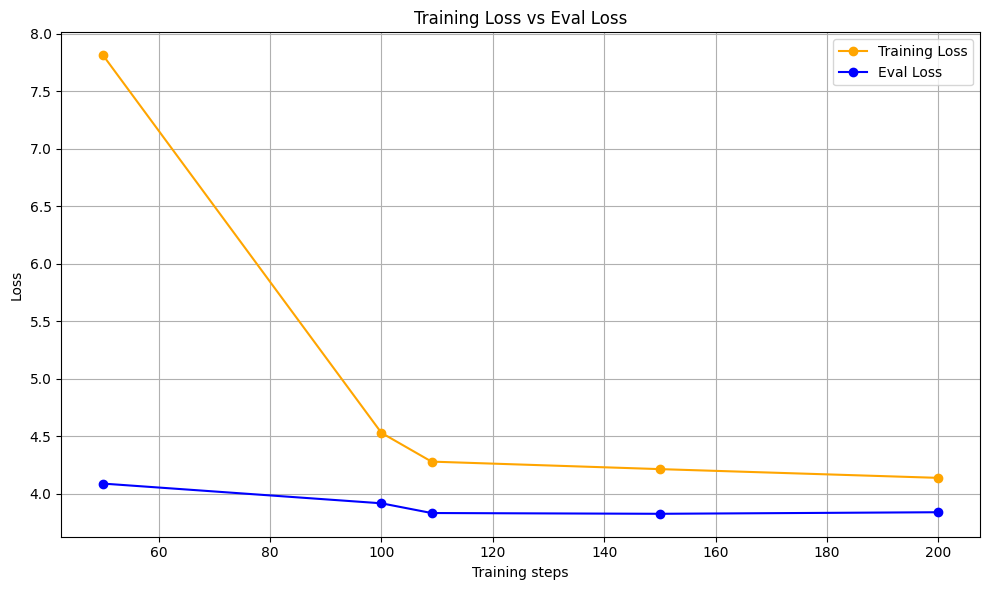

In [40]:
#Plot training and evaluation loss
plt.figure(figsize=(10,6))
plt.plot(steps[:min_len], train_loss[:min_len], label="Training Loss", color="Orange", marker="o")
plt.plot(steps[:min_len], eval_loss[:min_len], label="Eval Loss", color="Blue", marker="o")
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.title("Training Loss vs Eval Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

0 5


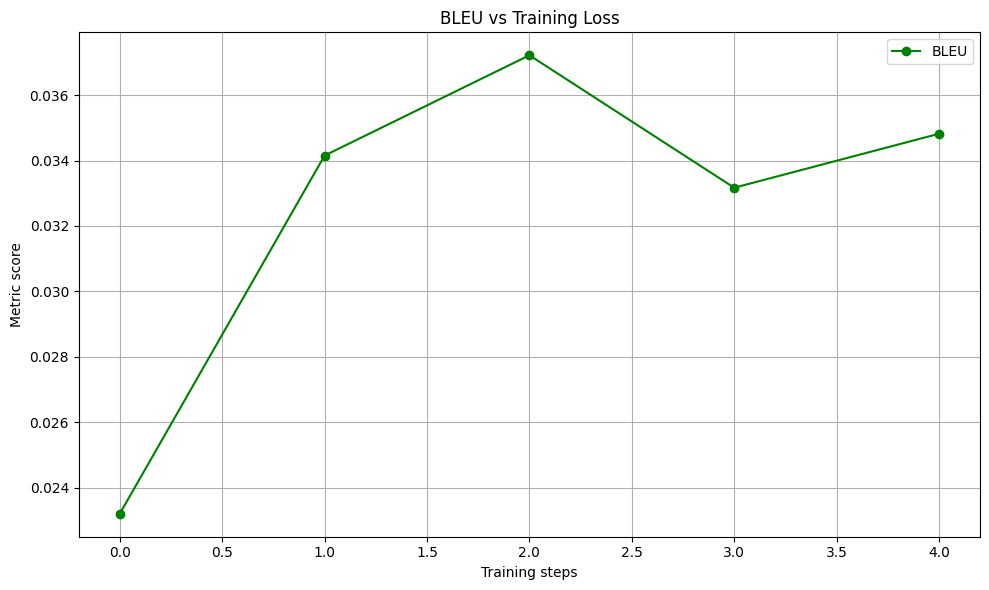

In [41]:
#Plot Bleu score vs Training loss
print(len(eval_steps), len(eval_bleu))
if len(eval_steps)==0:
    eval_steps=list(range(len(eval_bleu)))
plt.figure(figsize=(10,6))
plt.plot(eval_steps, eval_bleu, label="BLEU", marker="o", linestyle="-", color="green")
plt.xlabel("Training steps")
plt.ylabel("Metric score")
plt.title("BLEU vs Training Loss")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

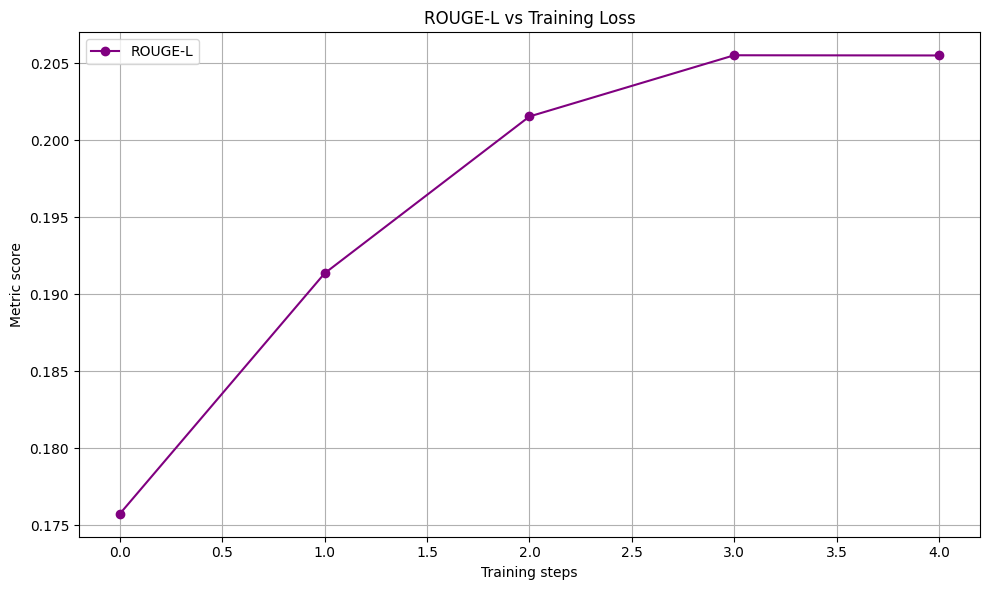

In [42]:
#Plot rouge vs Training loss
plt.figure(figsize=(10,6))
plt.plot(eval_steps, eval_rouge, label="ROUGE-L", marker="o", linestyle="-", color="purple")
plt.xlabel("Training steps")
plt.ylabel("Metric score")
plt.title("ROUGE-L vs Training Loss")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

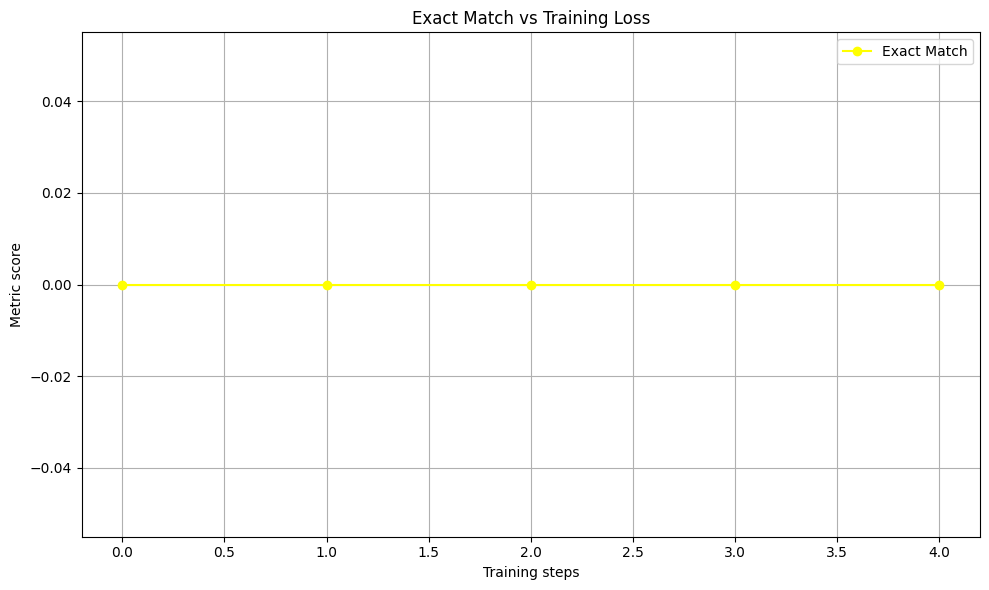

In [43]:
#Plot exact match
plt.figure(figsize=(10,6))
plt.plot(eval_steps, eval_exact_match, label="Exact Match", marker="o", linestyle="-", color="yellow")
plt.xlabel("Training steps")
plt.ylabel("Metric score")
plt.title("Exact Match vs Training Loss")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

In [44]:
#Define paths to saved model
model_path = "./t5_chatbot1_model"
tokenizer_path ="./t5-small"

#Load the tokenizer and model
tokenizer = T5Tokenizer.from_pretrained(tokenizer_path)
model = T5ForConditionalGeneration.from_pretrained(model_path)

#Set the model to eval mode
model.eval()

T5ForConditionalGeneration(
  (shared): Embedding(32100, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32100, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [45]:
#Generate a response using top_p top_k
def generate_response_top_k_top_p(
    question, model, tokenizer, max_length=256, top_k=50, top_p=0.95, temperature=1.0
):
      
    formatted_question = f"Question: {question}\nAnswer:"
    inputs = tokenizer(
        formatted_question,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=max_length,
    )
    
    outputs = model.generate(
        input_ids=inputs["input_ids"] ,
        attention_mask=inputs["attention_mask"],
        max_length=max_length,
        do_sample=True,
        top_k=top_k,
        top_p=top_p,
        num_beams=None,
        temperature=temperature,
        pad_token_id=tokenizer.pad_token_id,
    )
    response = tokenizer.decode(outputs[0], skip_special_token=True)
    return response

In [47]:
question = "what is multiple sclerosis"
response = generate_response_top_k_top_p(question, model, tokenizer)
print("Question:", question)
print("Answer:", response)

Question: what is multiple sclerosis
Answer: <pad> Multiple sclerosis is a disorder that has symptoms of a multiple diagnosis. it may include the inability to talk, or the mental inability to get information on how to recognize, protect and treat patients with the condition.</s>


In [54]:
question = "what is gullain-barr-syndrome"
response = generate_response_top_k_top_p(question, model, tokenizer)
print("Question:", question)
print("Answer:", response)

Question: what is gullain-barr-syndrome
Answer: </s>Question: what is gullain-barr-syndrome Answer: the patient's report or his medical record? < / FREETEXT > < / TITLE > ▃ </s>


In [55]:
#We are not getting the response we want. Let us use BioGPT-Large to get more accurate answers
#Import transformers
from transformers import BioGptTokenizer, BioGptForCausalLM
model_name = "microsoft/BioGPT-Large"
tokenizer = BioGptTokenizer.from_pretrained(model_name)
model = BioGptForCausalLM.from_pretrained(model_name)

In [56]:
#Set the model to evaluation mode
model.eval()

BioGptForCausalLM(
  (biogpt): BioGptModel(
    (embed_tokens): BioGptScaledWordEmbedding(57717, 1600, padding_idx=1)
    (embed_positions): BioGptLearnedPositionalEmbedding(2050, 1600)
    (layers): ModuleList(
      (0-47): 48 x BioGptDecoderLayer(
        (self_attn): BioGptSdpaAttention(
          (k_proj): Linear(in_features=1600, out_features=1600, bias=True)
          (v_proj): Linear(in_features=1600, out_features=1600, bias=True)
          (q_proj): Linear(in_features=1600, out_features=1600, bias=True)
          (out_proj): Linear(in_features=1600, out_features=1600, bias=True)
        )
        (activation_fn): GELUActivation()
        (self_attn_layer_norm): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (fc1): Linear(in_features=1600, out_features=6400, bias=True)
        (fc2): Linear(in_features=6400, out_features=1600, bias=True)
        (final_layer_norm): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
      )
    )
    (layer_norm): LayerNorm((

In [57]:
#Define a function to generate a response
def generate_detailed_medical_response(question, tokenizer, model, max_length=200, max_new_tokens=200):
    
    formatted_question = (
        f"Title: {question}\n"
        f"Abstract:"
    )
    #Tokenize the inputs
    inputs = tokenizer(
        formatted_question,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=max_length,
    )
    #Tokenize the responses
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        do_sample=True,
        max_new_tokens=max_new_tokens,
        num_beams=5,
        early_stopping=True,
        pad_token_id=tokenizer.pad_token_id,
    )
    #Decode outputs
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    response = decoded.replace(formatted_question, " ").strip()
    return response
    


In [52]:
question = "What is gullain barre syndrome"
response = generate_detailed_medical_response(question, tokenizer, model)
print("Question:", question)
print("Response:", response)

Question: What is gullain barre syndrome
Response: Title: What is gullain barre syndrome Abstract: Gullain Barre syndrome (GBS) is an autoimmune disorder of the peripheral nervous system characterized by acute flaccid paralysis, areflexia, and sensory changes. It is the most common cause of acute flaccid paralysis in the United States, with an incidence of 1. 3 cases per 1 0 0, 0 0 0 person-years. GBS is classified into acute inflammatory demyelinating polyradiculoneuropathy (AIDP), acute motor axonal neuropathy (AMAN), and acute motor and sensory axonal neuropathy (AMSAN). AIDP is the most common subtype, accounting for 6 0% to 7 0% of cases, followed by AMAN (2 0% to 2 5%) and AMSAN (1 0% to 1 5%). < / FREETEXT > < / ABSTRACT > ▃


In [63]:
question = "How is hypertension treated"
response = generate_detailed_medical_response(question, tokenizer, model)
print("Question:", question)
print("Response:", response)

Question: How is hypertension treated
Response: Title: How is hypertension treated Abstract: Hypertension is a major risk factor for cardiovascular morbidity and mortality. The prevalence of hypertension increases with age and is more common in men than in women. The treatment of hypertension is aimed at reducing blood pressure (BP) to < 1 4 0 / 9 0 mm Hg. This can be achieved in most patients with a combination of two or more antihypertensive agents. Lifestyle modification is an important part of the management of hypertension. < / FREETEXT > < / ABSTRACT > ▃


In [56]:
question = "How is prostate cancer diagnosed"
response = generate_detailed_medical_response(question, tokenizer, model)
print("Question:", question)
print("Response:", response)

Question: How is prostate cancer diagnosed
Response: Title: How is prostate cancer diagnosed Abstract: Prostate cancer is the most common noncutaneous malignancy and the second leading cause of cancer-related death in men in the United States. Prostate-specific antigen (PSA) testing has led to a significant increase in the diagnosis of early-stage prostate cancer. However, the risk of overdiagnosis and overtreatment of low-risk prostate cancer remains high. The 2 0 1 2 American Urological Association (AUA) / American Society for Radiation Oncology (ASTRO) / International Society of Geriatric Oncology (SIOG) guidelines recommend active surveillance (AS) for men with low-risk prostate cancer who are willing to accept the risk of overdiagnosis and overtreatment. The 2 0 1 5 National Comprehensive Cancer Network (NCCN) guidelines recommend AS for men with low-risk prostate cancer who are willing to accept the risk of overdiagnosis and overtreatment. The AUA / ASTRO / SIOG guidelines and th

In [65]:
question = "What is breast cancer?"
response = generate_detailed_medical_response(question, tokenizer, model)
print("Question:", question)
print("Response:", response)

Question: What is breast cancer?
Response: Title: What is breast cancer? Abstract: Breast cancer is the most common cancer in women worldwide and a leading cause of cancer-related death in women in the United States. Breast cancer is a heterogeneous disease, both clinically and molecularly. It is important to understand the molecular subtypes of breast cancer and how these subtypes differ in terms of prognosis and response to therapy. < / FREETEXT > < / PARAGRAPH > ▃ < PARAGRAPH > < FREETEXT > The molecular subtypes of breast cancer have been defined by gene expression profiling and include luminal A, luminal B, human epidermal growth factor receptor 2 (HER2) -enriched, basal-like, and claudin-low subtypes. The luminal A and luminal B subtypes are estrogen receptor (ER) – positive, and the HER2-enriched and basal-like subtypes are ER-negative. The claudin-low subtype is ER-negative, progesterone receptor (PR) – negative, and HER2-negative. The basal-like and claudin-low subtypes are ch

In [66]:
def generate_detailed_medical_response(question, tokenizer, model, max_length=200, max_new_tokens=200):
    formatted_question = (
        f"Title: {question}\n"
        f"Abstract:"
    )
    inputs = tokenizer(
        formatted_question,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=max_length,
    )
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        do_sample=False,
        early_stopping=True,
        num_beams=5,
        pad_token_id=tokenizer.pad_token_id
    )
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    response = decoded.replace(formatted_question, " ").strip()
    return response

In [ ]:
#Import Libraries
import tkinter as tk
from tkinter import *
from transformers import BioGptTokenizer, BioGptForCausalLM

In [71]:
#Build GUI Logic
def chatbot_response(question):
    return generate_detailed_medical_response(question, tokenizer, model)

In [76]:
def send():
    msg = EntryBox.get("1.0", "end-1c").strip()
    EntryBox.delete("0.0", END)
    if msg != "":
        ChatLog.config(state=NORMAL)
        ChatLog.insert(END, "You: " + msg + "\n\n")
        ChatLog.config(foreground = "#442265", font=("Verdana", 12))
        res = chatbot_response(msg)
        ChatLog.insert(END, "BIOGPT: " + res + "\n\n")
        ChatLog.config(state=DISABLED)
        ChatLog.yview(END)
#Build GUI
base = tk.Tk()
base.title("BioGPT Medical Q&A")
base.geometry("500x600")
base.resizable(width=False, height=False)
ChatLog = Text(base, bd=0, bg="white", height="8", width="50", font="Arial", wrap=WORD)
ChatLog.config(state=DISABLED)
scrollbar = Scrollbar(base, command=ChatLog.yview, cursor="heart")
ChatLog["yscrollcommand"] = scrollbar.set
SendButton = Button(base, font=("Verdana", 12, "bold"), text="Ask", width="12", height=5, bd=0, bg="#32de97", activebackground="#3c9d9b", fg="#ffffff", command=send)
EntryBox = Text(base, bd=0, bg="white", width="29", height="5", font="Arial")
EntryBox.bind("<Return>", lambda event: send())
scrollbar.place(x=476, y=6, height=486)
ChatLog.place(x=6, y=6, height=486)
EntryBox.place(x=128, y=501, height=90, width=365)
SendButton.place(x=6, y=501, height=90)
base.mainloop()

In [67]:
#Let us try chainlit for better perfomance
#Define functions that handles incoming messages
import chainlit as cl
@cl.on_message
async def handle_message(message: cl.Message):
    user_question = message.content
    await cl.Message(content="Generating Medical Respons. Please Await...").send()
    response = generate_detailed_medical_response(user_question, tokenizer, model)
    await cl.Message(content=response).send()

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
bio_model_name = "microsoft/BioGPT-Large"
bio_model_tokenizer = AutoTokenizer.from_pretrained(model_name)
bio_model = AutoModelForCausalLM.from_pretrained(model_name)

mistral_model_name = "mistralai/Mistral-7B-Instruct-v0.2"
mistral_tokenizer = AutoTokenizer.from_pretrained(simple_model_name)
mistral_model = AutoModelForCausalLM.from_pretrained(simple_model_name)

def generate_detailed_medical_response(question, tokenizer, model, max_length=200, max_new_tokens=200):
    formatted_question = (
        f"Title: {question}\n"
        f"Abstract:"
    )
    inputs = tokenizer(
        formatted_question,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=max_length,
    )
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        do_sample=False,
        early_stopping=True,
        num_beams=5,
        pad_token_id=tokenizer.pad_token_id
    )
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    response = decoded.replace(formatted_question, " ").strip()
    return response

#Simplify for a non-medical audience
def simplified_medical_answer(raw_answer, tokenizer, model, max_length=200, max_new_tokens=200):
    simplified_answer = f"Explain this for a general audience:\n\n{raw_answer}\n\nSimplified Answer"
    inputs = tokenizer(
        simplified_answer,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=max_length,
    )
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        do_sample=False,
        early_stopping=True,
        num_beams=5,
        pad_token_id=tokenizer.pad_token_id
    )
    simplified_decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    response = simplified_decoded.replace(simplified_answer, " ").strip()
    return response